# SKM human ageing dataset: hindlimb in old (19 m/o) and young (3 m/o) male mice 

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import gseapy

import matplotlib.pyplot as plt
import plotnine as p9
import seaborn as sns

import warnings
import os
import urllib.request
import tempfile

In [5]:
# Load the data
dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/human_SKM_ageing_atlas_2024"
mice_anndata = os.path.join(dir, "mice_hindlimb_myofiber.h5ad")
#human_intercostal_anndata = os.path.join(dir, "human_male_intercostal_myofiber.h5ad")
adata = sc.read_h5ad(mice_anndata)
#adata = sc.read_h5ad(human_intercostal_anndata)



In [6]:
adata



AnnData object with n_obs × n_vars = 26385 × 15721
    obs: 'SampleID', 'Age_bin', 'annotation', 'n_counts', 'n_genes', 'mito_per', 'scrublet_score', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'GeneID', 'feature_types', 'GeneName', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'annotation_colors', 'cell_type_colors', 'citation', 'default_embedding', 'development_stage_colors', 'rank_genes_groups', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_scVI', 'X_umap'

In [7]:
adata.var['GeneName'][0:10] # index still has a few ensembl ids, gene names are all symbols

Xkr4                     Xkr4
Gm1992                 Gm1992
Rp1                       Rp1
Sox17                   Sox17
Mrpl15                 Mrpl15
ENSMUSG00000104217    Gm37988
Tcea1                   Tcea1
Rgs20                   Rgs20
Atp6v1h               Atp6v1h
Rb1cc1                 Rb1cc1
Name: GeneName, dtype: object

In [6]:
display(adata.var.head().style.set_properties(subset=["feature_name"], **{"width": "300px"})) 

,GeneID,feature_types,GeneName,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length
Xkr4,ENSMUSG00000051951,Gene Expression,Xkr4,False,Xkr4,NCBITaxon:10090,gene,6094
Gm1992,ENSMUSG00000089699,Gene Expression,Gm1992,False,Gm1992,NCBITaxon:10090,gene,250
Rp1,ENSMUSG00000025900,Gene Expression,Rp1,False,Rp1,NCBITaxon:10090,gene,12311
Sox17,ENSMUSG00000025902,Gene Expression,Sox17,False,Sox17,NCBITaxon:10090,gene,4772
Mrpl15,ENSMUSG00000033845,Gene Expression,Mrpl15,False,Mrpl15,NCBITaxon:10090,gene,8487


In [7]:
print(adata.X.min())
print(adata.X.max())
print(adata.raw.X.min())
print(adata.raw.X.max())



0.0
8.493203
0.0
1697.0


## Selecting cell populations of interest for comparison
### Mainly useful for comparing human age groups and myofiber II cell types

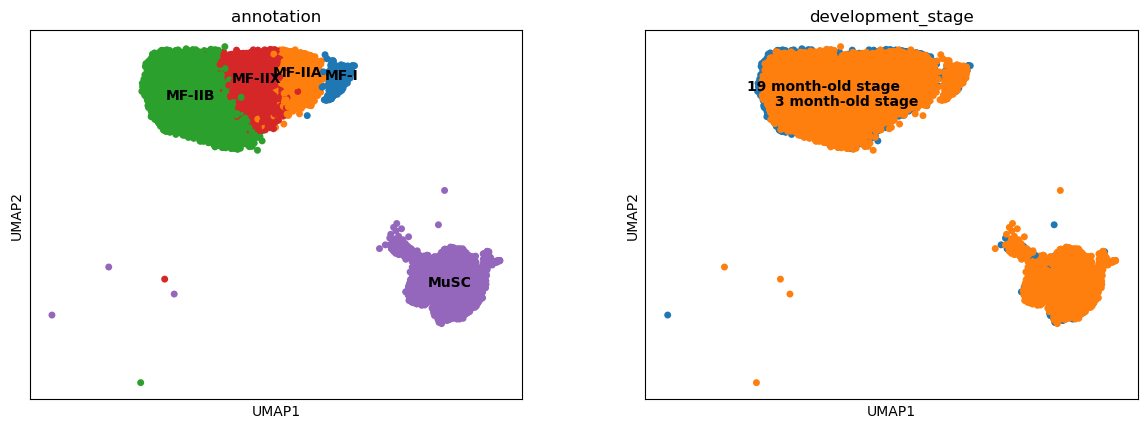

In [9]:
sc.pl.umap(adata, color=["annotation", "development_stage"], legend_loc="on data", size=100)

In [8]:
# Define your categories
groupby_category = 'development_stage'   # Example: age groups, to go on x-axis
celltype_category = 'annotation'  # Example: cell types, to be shown with dots

# Step 1: Create a contingency table (cross-tabulate the two categories)
contingency_table = pd.crosstab(adata.obs[groupby_category], adata.obs[celltype_category])

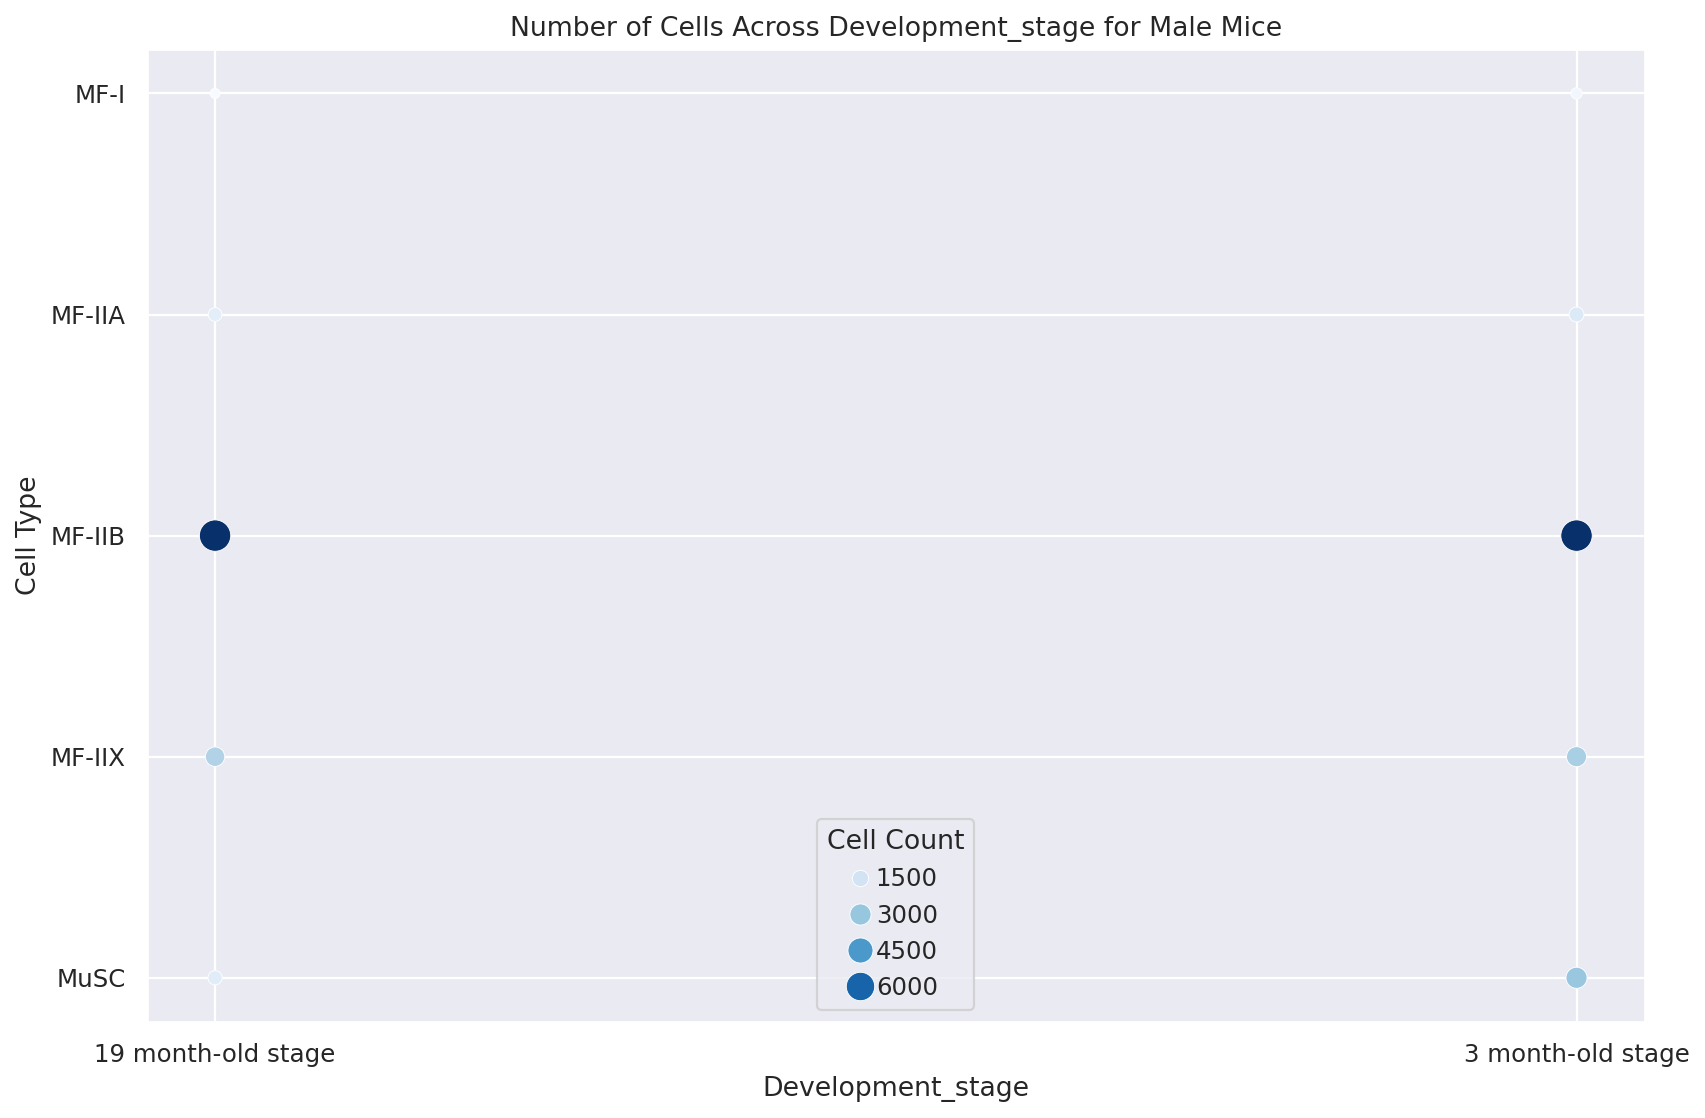

In [9]:
# Plot raw cell counts
# Step 2: Reshape the data to plot (melt the dataframe to long format for seaborn)
count_df = contingency_table.reset_index().melt(id_vars=groupby_category, var_name='celltype_category', value_name='cell_count')

# Step 3: Plot a dot plot using seaborn's scatterplot where dot size represents the number of cells
plt.figure(figsize=(12, 8))
sns.scatterplot(data=count_df, x=groupby_category, y='celltype_category', size='cell_count', sizes=(20, 200), hue='cell_count', palette='Blues')

# Customize labels and title
plt.title(f"Number of Cells Across {groupby_category.capitalize()} for Male Mice")
plt.xlabel(groupby_category.capitalize())
plt.ylabel("Cell Type")
plt.legend(title="Cell Count")

plt.show()

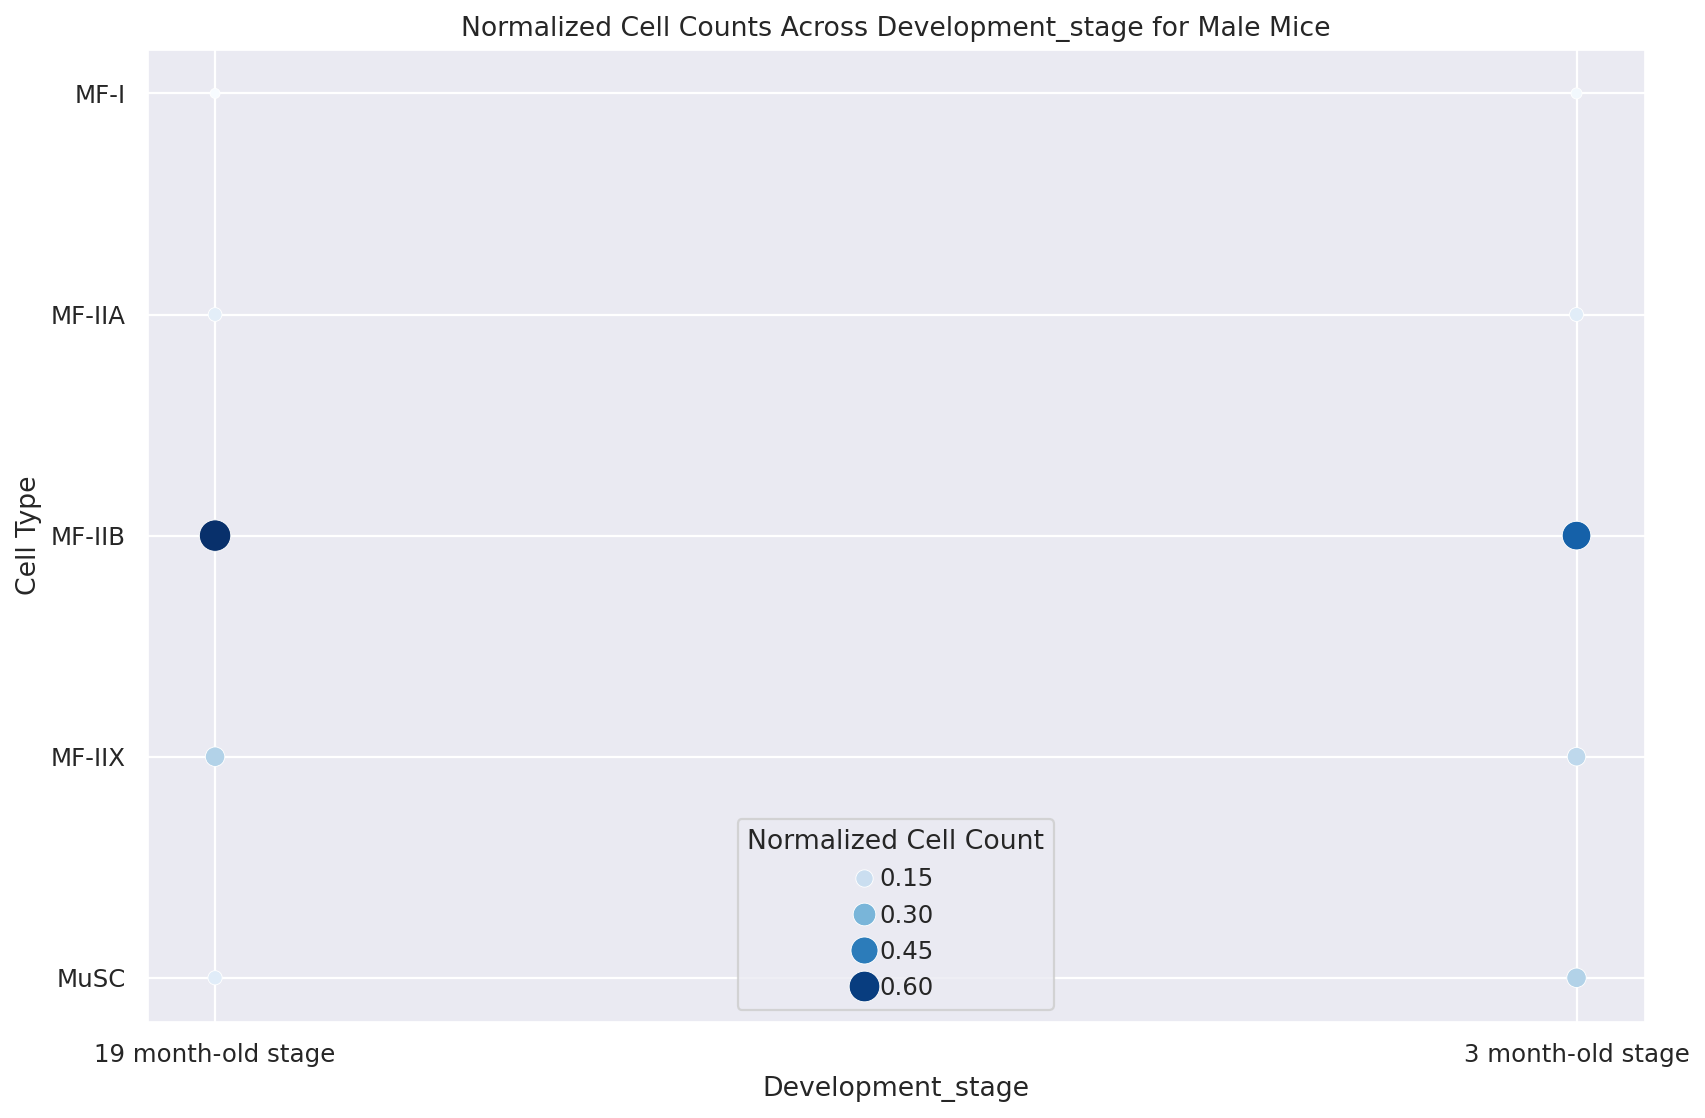

In [10]:
# plot normalized cell counts (normalized across development stage so that each developmental stage has total equal cells)
# Step 2: Normalize the cell counts within each development stage (row-wise normalization)
normalized_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Step 3: Reshape the normalized data to plot (melt the dataframe to long format for seaborn)
normalized_df = normalized_table.reset_index().melt(id_vars=groupby_category, var_name='celltype_category', value_name='normalized_cell_count')

# Step 4: Plot a dot plot using seaborn's scatterplot where dot size represents the normalized cell counts
plt.figure(figsize=(12, 8))
sns.scatterplot(data=normalized_df, x=groupby_category, y='celltype_category', size='normalized_cell_count', sizes=(20, 200), hue='normalized_cell_count', palette='Blues')

# Customize labels and title
plt.title(f"Normalized Cell Counts Across {groupby_category.capitalize()} for Male Mice")
plt.xlabel(groupby_category.capitalize())
plt.ylabel("Cell Type")
plt.legend(title="Normalized Cell Count")

plt.show()

## Standard DEG analysis without accounting for covariates/fitting models per factor of variation

#### Pre-process genes

In [10]:
# Storing the counts for later use
adata.layers["counts"] = adata.raw.X.copy()

In [11]:
adata.X = adata.layers["counts"]

In [12]:
# Normalizing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [14]:
# Finding highly variable genes using count data
sc.pp.highly_variable_genes(
    adata, n_top_genes=4000, flavor="cell_ranger", subset=False, layer="counts"
)
adata

AnnData object with n_obs × n_vars = 26385 × 15721
    obs: 'SampleID', 'Age_bin', 'annotation', 'n_counts', 'n_genes', 'mito_per', 'scrublet_score', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'GeneID', 'feature_types', 'GeneName', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annotation_colors', 'cell_type_colors', 'citation', 'default_embedding', 'development_stage_colors', 'rank_genes_groups', 'schema_reference', 'schema_version', 'title', 'log1p', 'hvg'
    obs

#### Recomputing the pca and umap without batch correction for age groups

In [15]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

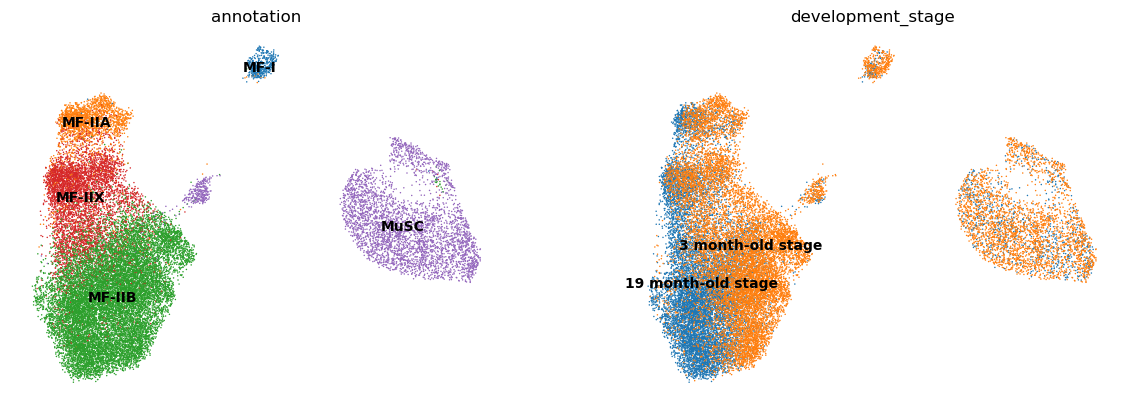

In [17]:
sc.pl.umap(
    adata,
    color=["annotation", "development_stage"],
    frameon=False,
    legend_loc="on data",
    ncols=2,
)

#### Group cells according to age_celltype for DEG analysis

In [ ]:
adata.obs["group"] = adata.obs.development_stage.astype("string") + "_" + adata.obs.annotation
# find DE genes by wilcoxon rank sum test, groupby is the obs column.
sc.tl.rank_genes_groups(adata, groupby="group", groups='all', reference="rest", method="wilcoxon", key_added="wilcoxon_deg")



## Accounting for important covariates in human cell populations apart from age, when comparing cell populations across age groups for differential gene expression:
### 1. Pseudobulking and then doing DEG analysis circumvents the covariates/confounders which are unknown
### 2. Fitting linear mixed models per factor of variation (e.g. sex, age, etc.) allows for accounting for these covariates (scvi/lme4, etc)